# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from numpy import random 
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from bs4 import BeautifulSoup


import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from sklearn.metrics import roc_curve,accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# using SQLite Table to read data.

con = sqlite3.connect('drive/My Drive/FFRDB/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [0]:
final.sort_values('Time',inplace=True)
print(final.head(5))

          Id  ...                                               Text
70688  76882  ...  I bought a few of these after my apartment was...
1146    1245  ...  This was a really good idea and the final prod...
1145    1244  ...  I just received my shipment and could hardly w...
28086  30629  ...  Nothing against the product, but it does bothe...
28087  30630  ...  I love this stuff. It is sugar-free so it does...

[5 rows x 10 columns]


In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
we use this as the base, then besides the chicken, we will also add pasta, spices, veggies, or whatever we have around to make quick cheesy meals
My dogs just love this food. The service is always fast and reliable.
I am amazed by how well this tea works to relieve my chronic congestion and recurring sinus problems. And it's not just a "quick" fix either -- its therapeutic effects last for hours. I was a bit worried the tea would be a bit too "licorice-y" since one of its main ingredients is licorice root, but the fragrance and taste are mild and incredibly soothing. If you think this package of six boxes is too much, you'll be ha

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had "attracted" many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
we use this as the base, then besides the chicken, we will also add pasta, spices, veggies, or whatever we have around to make quick cheesy meals
My dogs just love this food. The service is always fast and reliable.
I am amazed by how well this tea works to relieve my chronic congestion and recurring sinus problems. And it's not just a "quick" fix either -- its therapeutic effects last for hours. I was a bit worried the tea would be a bit too "licorice-y" since one of its main ingredients is licorice root, but the fragrance and taste are mild and incredibly soothing. If you think this package of six boxes is too much, you'll be happily prov

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

My dogs just love this food. The service is always fast and reliable.


In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

My dogs just love this food The service is always fast and reliable 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:29<00:00, 2962.91it/s]


In [0]:
preprocessed_reviews[1500]

'dogs love food service always fast reliable'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

### Loading tfidf and avg W2V pickles of 100k points

In [0]:
dbfile1 = open('/content/drive/My Drive/FFRDB/tfidf.pkl', 'rb')  
tfidf_sent_vectors = pickle.load(dbfile1)  


dbfile2 = open('/content/drive/My Drive/FFRDB/sent_vectors.pkl', 'rb') 
sent_vectors= pickle.load(dbfile2)

# [5] Assignment 8: Decision Trees

<ol>
    <li><strong>Apply Decision Trees on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best `depth` in range [4,6, 8, 9,10,12,14,17] , and the best `min_samples_split` in range [2,10,20,30,40,50])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Graphviz</strong>
        <ul>
    <li>Visualize your decision tree with Graphviz. It helps you to understand how a decision is being made, given a new vector.</li>
    <li>Since feature names are not obtained from word2vec related models, visualize only BOW & TFIDF decision trees using Graphviz</li>
    <li>Make sure to print the words in each node of the decision tree instead of printing its index.</li>
    <li>Just for visualization purpose, limit max_depth to 2 or 3 and either embed the generated images of graphviz in your notebook, or directly upload them as .png files.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 20 important features from both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using `feature_importances_` method of <a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>Decision Tree Classifier</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>min_sample_split</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>min_sample_split</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Decision Trees

## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews[:100000],final['Score'].values[:100000],test_size=0.3,random_state=0)

vectorizer = CountVectorizer(ngram_range=(1,2), min_df=10, max_features= 500)
vectorizer.fit(X_train) 
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)


print(X_train.shape)
print(X_test.shape)

(70000, 500)
(30000, 500)


In [0]:
depth=[2,3,4,6, 8, 9,10,12,14,17]
samples= [2,10,20,30,40,50]
param = {'max_depth':depth,'min_samples_split':samples}

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
DT=DecisionTreeClassifier(class_weight='balanced')
temp_gscv= GridSearchCV(DT,param,cv=5,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.6min finished


In [0]:
train_auc=temp_gscv.cv_results_['mean_train_score']
cv_auc=temp_gscv.cv_results_['mean_test_score']

#code snippet from provided 3d scappter plot .ipynb file


import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
import numpy as np

x1 = samples*len(depth)
y1 = depth*len(samples)
z1 = train_auc

x2 = samples*len(depth)
y2 = depth*len(samples)
z2 = cv_auc

# https://plot.ly/python/3d-axes/
trace1 = go.Scatter3d(x=x1,y=y1,z=z1, name = 'train')
trace2 = go.Scatter3d(x=x2,y=y2,z=z2, name = 'CV')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='Sample_size'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
fig.show(renderer='colab')
offline.iplot(fig, filename='3d-scatter-colorscale')

Output hidden; open in https://colab.research.google.com to view.

Train AUC heatmap


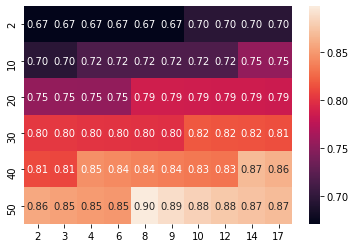

In [0]:
print('Train AUC heatmap')
hm = pd.DataFrame(data= train_auc.reshape(len(samples),len(depth)),index=samples,columns=depth)
sns.heatmap(hm, annot=True,fmt='.2f')

CV AUC heatmap


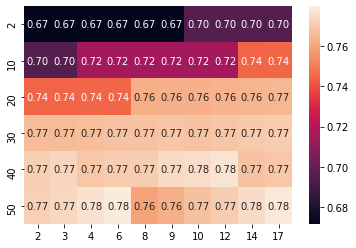

In [0]:
print('CV AUC heatmap')
hm = pd.DataFrame(data= cv_auc.reshape(len(samples),len(depth)),index=samples,columns=depth)
sns.heatmap(hm, annot=True,fmt='.2f')

In [0]:
#finding the best CV scores that is maximas then using the one which is least distant then its AUC counter part to derive  
# C and gamma to avoid using Dumb model.

from scipy.signal import argrelextrema
import numpy as np
x = np.array(train_auc)
y = np.array(cv_auc)

local_max=()
diff=x-y

#finding index of maximas of CV scores 
local_max_i=argrelextrema(y, np.greater)

#generating a list of indexs for maximas
l=list(i for i in local_max_i[0])

#generating list of indices in neighbor of maximas to check
k=[]
neighbor=0
for i in l:
  if i >neighbor and i<len(y):
    k.extend(range(i-neighbor,i+neighbor+1))
  elif i<neighbor and i < len(y):
    k.extend(range(i,i+neighbor+1))
  else:
    k.extend(range(i-neighbor,i+1))
l=k

# diff between CV and Test AUC at the local maximas
local_diff=list(diff[i] for i in l)
print(f'all local differences {local_diff}')

#fetching the index where local diff is min
for i in np.nditer(np.argmin(local_diff)):
  v=i
  break
print(f'best cv score to use = {y[l[v]]}')


best_index= l[v]

print('best index {}'.format(best_index))

# as index are in range of 0 to hundread 
# for differnt permutation of C and gamma
# fetching the C and Gamma index from them

best_depth=depth[int((best_index-(best_index%len(depth)))/len(depth))]
print(f'best depth to use = {best_depth}')

best_size=samples[best_index%len(samples)]
print('best sample split size to use = {}'.format(best_size))

all local differences [0.0027433294082693793, 0.010103818939499964, 0.009610581708917154, 0.03263047275038422, 0.02982668060381599, 0.0374185696130932, 0.054562835783217745, 0.06945231155528653]
best cv score to use = 0.7154955599266588
best index 13
best depth to use = 3
best sample split size to use = 10


In [0]:
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_curve, auc
from sklearn.tree import DecisionTreeClassifier


DT=DecisionTreeClassifier(min_samples_split= best_size, max_depth= best_depth,class_weight='balanced')

DT.fit(X_train,y_train)
y_pred_tr = DT.predict_proba(X_train)
y_pred_ts = DT.predict_proba(X_test)
y_pred_tr=y_pred_tr[:,1]
y_pred_ts=y_pred_ts[:,1]

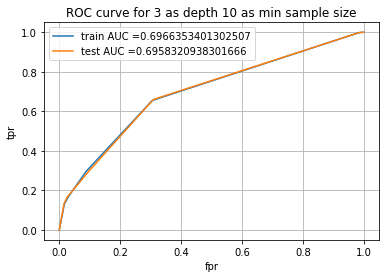

In [0]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred_ts)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title('ROC curve for '+str (best_depth)+' as depth '+str(best_size)+ ' as min sample size')
plt.legend()
plt.grid()
plt.show()

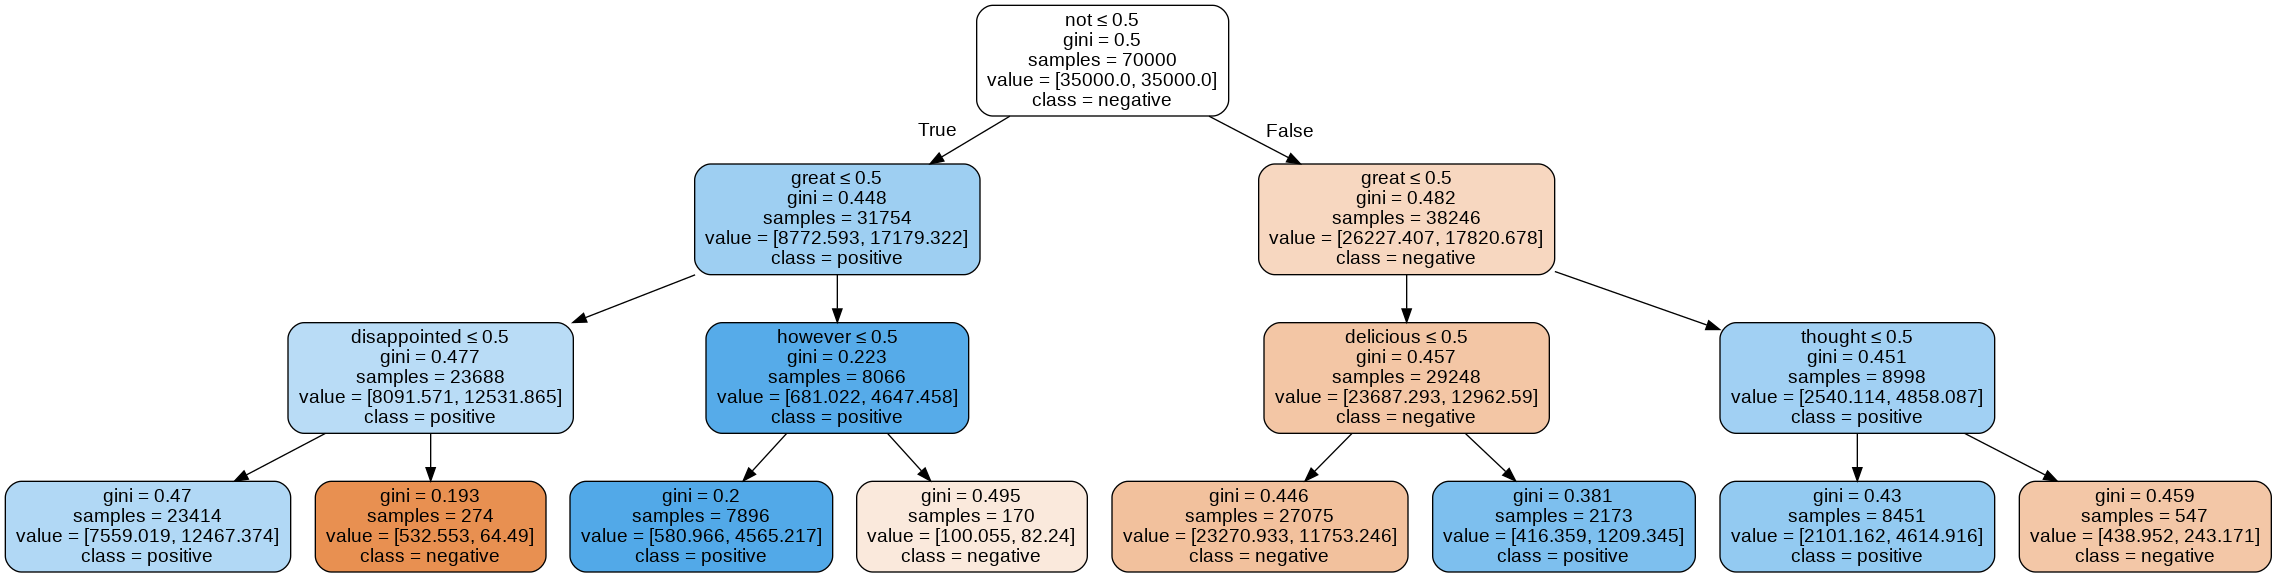

In [0]:
import pydotplus
from IPython.display import Image
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

target = ['negative','positive']
data = tree.export_graphviz(DT,out_file=None,max_depth=3,class_names=target,
                            filled=True,rounded=True,special_characters=True,
                            feature_names=vectorizer.get_feature_names()) 
graph = pydotplus.graph_from_dot_data(data)
Image(graph.create_png())

In [0]:
# This section of code where ever implemented is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


print('test')
best_ts_thres = find_best_threshold(te_thresholds, test_fpr, test_tpr)

test
the maximum value of tpr*(1-fpr) 0.4548245157469292 for threshold 0.451


Test Confusion Matrix


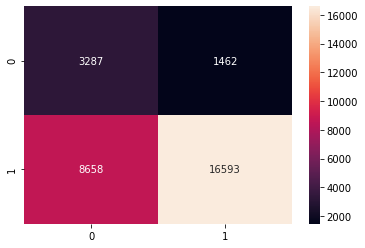

In [0]:
print('Test Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_pred_ts, best_ts_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

In [0]:
acc=accuracy_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
ps=precision_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
rc=recall_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
f1=f1_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 66.27%
Precision on test set: 91.90%
recall score on test set: 65.71%
f1 score on test set: 76.63%


In [0]:
count=0
value=[]
for i in DT.feature_importances_.reshape(-1,1):
  count+=1
  value.extend(i)

x=vectorizer.get_feature_names()

features= pd.DataFrame({'feature_name':x,'value':value})

In [0]:
features.sort_values(by = ['value'], ascending=False,ignore_index=True).head(20)

,feature_name,value
0,not,0.440351
1,great,0.350582
2,delicious,0.105422
3,disappointed,0.062470
4,thought,0.027555
5,however,0.013620
6,pepper,0.000000
7,per,0.000000
8,perfect,0.000000
9,pieces,0.000000


In [0]:
features.sort_values(by = ['value'], ascending=True,ignore_index=True).head(20)

,feature_name,value
0,able,0.0
1,popcorn,0.0
2,plus,0.0
3,pleased,0.0
4,plastic,0.0
5,plain,0.0
6,place,0.0
7,pieces,0.0
8,perfect,0.0
9,per,0.0


### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews[:100000],final['Score'].values[:100000],test_size=0.3,random_state=0)

vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features= 500)
vectorizer.fit(X_train) 
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)


print(X_train.shape)
print(X_test.shape)

(70000, 500)
(30000, 500)


In [0]:
depth=[2,3,4,6, 8, 9,10,12,14,17]
samples= [2,10,20,30,40,50]
param = {'max_depth':depth,'min_samples_split':samples}

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
DT=DecisionTreeClassifier(class_weight='balanced')
temp_gscv= GridSearchCV(DT,param,cv=5,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'ma

In [0]:
train_auc=temp_gscv.cv_results_['mean_train_score']
cv_auc=temp_gscv.cv_results_['mean_test_score']

#code snippet from provided 3d scappter plot .ipynb file


import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
import numpy as np

x1 = samples*len(depth)
y1 = depth*len(samples)
z1 = train_auc

x2 = samples*len(depth)
y2 = depth*len(samples)
z2 = cv_auc

# https://plot.ly/python/3d-axes/
trace1 = go.Scatter3d(x=x1,y=y1,z=z1, name = 'train')
trace2 = go.Scatter3d(x=x2,y=y2,z=z2, name = 'CV')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='Sample_size'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
fig.show(renderer='colab')
offline.iplot(fig, filename='3d-scatter-colorscale')

Output hidden; open in https://colab.research.google.com to view.

Train AUC heatmap


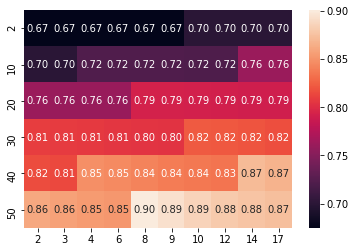

In [0]:
print('Train AUC heatmap')
hm = pd.DataFrame(data= train_auc.reshape(len(samples),len(depth)),index=samples,columns=depth)
sns.heatmap(hm, annot=True,fmt='.2f')

CV AUC heatmap


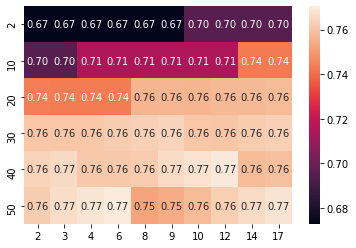

In [0]:
print('CV AUC heatmap')
hm = pd.DataFrame(data= cv_auc.reshape(len(samples),len(depth)),index=samples,columns=depth)
sns.heatmap(hm, annot=True,fmt='.2f')

In [0]:
#finding the best CV scores that is maximas then using the one which is least distant then its AUC counter part to derive  
# C and gamma to avoid using Dumb model.

from scipy.signal import argrelextrema
import numpy as np
x = np.array(train_auc)
y = np.array(cv_auc)

local_max=()
diff=x-y

#finding index of maximas of CV scores 
local_max_i=argrelextrema(y, np.greater)

#generating a list of indexs for maximas
l=list(i for i in local_max_i[0])

#generating list of indices in neighbor of maximas to check
k=[]
neighbor=0
for i in l:
  if i >neighbor and i<len(y):
    k.extend(range(i-neighbor,i+neighbor+1))
  elif i<neighbor and i < len(y):
    k.extend(range(i,i+neighbor+1))
  else:
    k.extend(range(i-neighbor,i+1))
l=k

# diff between CV and Test AUC at the local maximas
local_diff=list(diff[i] for i in l)
print(f'all local differences {local_diff}')

#fetching the index where local diff is min
for i in np.nditer(np.argmin(local_diff)):
  v=i
  break
print(f'best cv score to use = {y[l[v]]}')


best_index= l[v]

print('best index {}'.format(best_index))

# as index are in range of 0 to hundread 
# for differnt permutation of C and gamma
# fetching the C and Gamma index from them

best_depth=depth[int((best_index-(best_index%len(depth)))/len(depth))]
print(f'best depth to use = {best_depth}')

best_size=samples[best_index%len(samples)]
print('best sample split size to use = {}'.format(best_size))

all local differences [0.018206688331966925, 0.017589886145419453, 0.03627272218883648, 0.03961845403280384, 0.04917057919827594, 0.06495383436655988, 0.08180810270357741]
best cv score to use = 0.7437892257181802
best index 20
best depth to use = 4
best sample split size to use = 20


In [0]:
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_curve, auc
from sklearn.tree import DecisionTreeClassifier


DT=DecisionTreeClassifier(min_samples_split= best_size, max_depth= best_depth,class_weight='balanced')

DT.fit(X_train,y_train)
y_pred_tr = DT.predict_proba(X_train)
y_pred_ts = DT.predict_proba(X_test)
y_pred_tr=y_pred_tr[:,1]
y_pred_ts=y_pred_ts[:,1]

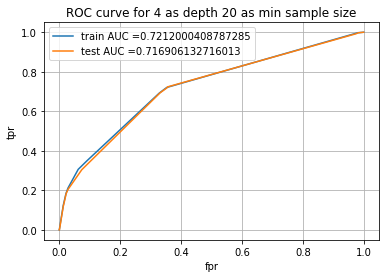

In [0]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred_ts)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title('ROC curve for '+str (best_depth)+' as depth '+str(best_size)+ ' as min sample size')
plt.legend()
plt.grid()
plt.show()

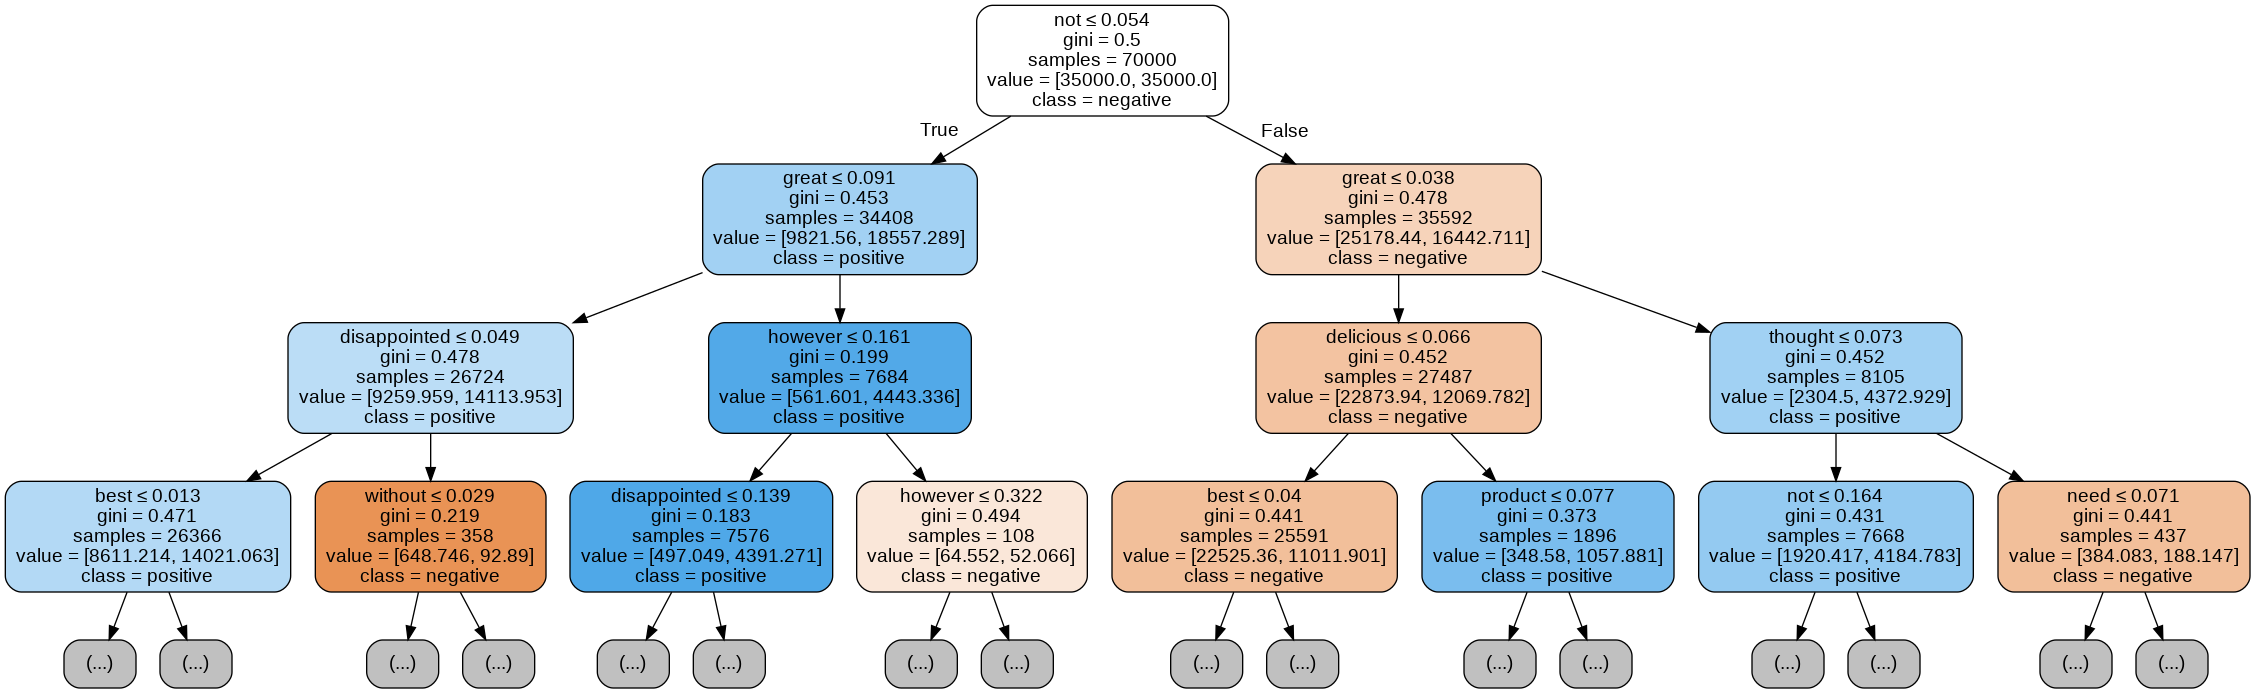

In [0]:
import pydotplus
from IPython.display import Image
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

target = ['negative','positive']
data = tree.export_graphviz(DT,out_file=None,max_depth=3,class_names=target,
                            filled=True,rounded=True,special_characters=True,
                            feature_names=vectorizer.get_feature_names()) 
graph = pydotplus.graph_from_dot_data(data)
Image(graph.create_png())

In [0]:
# This section of code where ever implemented is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [0]:
print('test')
best_ts_thres = find_best_threshold(te_thresholds, test_fpr, test_tpr)

test
the maximum value of tpr*(1-fpr) 0.4662846924646605 for threshold 0.394


Test Confusion Matrix


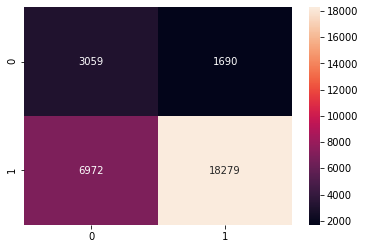

In [0]:
print('Test Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_pred_ts, best_ts_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

In [0]:
acc=accuracy_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
ps=precision_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
rc=recall_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
f1=f1_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 71.13%
Precision on test set: 91.54%
recall score on test set: 72.39%
f1 score on test set: 80.84%


In [0]:
count=0
value=[]
for i in DT.feature_importances_.reshape(-1,1):
  count+=1
  value.extend(i)

x=vectorizer.get_feature_names()

features= pd.DataFrame({'feature_name':x,'value':value})

In [0]:
features.sort_values(by = ['value'], ascending=False,ignore_index=True).head(20)

,feature_name,value
0,not,0.395319
1,great,0.291670
2,best,0.124243
3,delicious,0.081347
4,disappointed,0.064627
5,thought,0.022329
6,however,0.008934
7,product,0.006832
8,need,0.002596
9,without,0.002103


In [0]:
features.sort_values(by = ['value'], ascending=True,ignore_index=True).head(20)

## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(sent_vectors,final['Score'].values,test_size=0.3,random_state=0)

In [0]:
depth=[2,3,4,6, 8, 9,10,12,14,17]
samples= [2,10,20,30,40,50]
param = {'max_depth':depth,'min_samples_split':samples}

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
DT=DecisionTreeClassifier(class_weight='balanced')
temp_gscv= GridSearchCV(DT,param,cv=5,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 20.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'ma

In [0]:
train_auc=temp_gscv.cv_results_['mean_train_score']
cv_auc=temp_gscv.cv_results_['mean_test_score']

#code snippet from provided 3d scappter plot .ipynb file


import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
import numpy as np

x1 = samples*len(depth)
y1 = depth*len(samples)
z1 = train_auc

x2 = samples*len(depth)
y2 = depth*len(samples)
z2 = cv_auc

# https://plot.ly/python/3d-axes/
trace1 = go.Scatter3d(x=x1,y=y1,z=z1, name = 'train')
trace2 = go.Scatter3d(x=x2,y=y2,z=z2, name = 'CV')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='Sample_size'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
fig.show(renderer='colab')
offline.iplot(fig, filename='3d-scatter-colorscale')

Output hidden; open in https://colab.research.google.com to view.

Train AUC heatmap


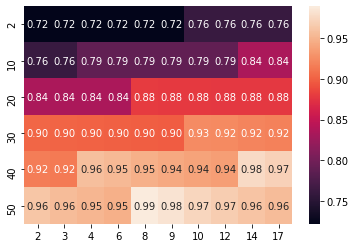

In [0]:
print('Train AUC heatmap')
hm = pd.DataFrame(data= train_auc.reshape(len(samples),len(depth)),index=samples,columns=depth)
sns.heatmap(hm, annot=True,fmt='.2f')

CV AUC heatmap


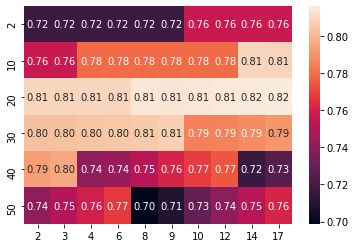

In [0]:
print('CV AUC heatmap')
hm = pd.DataFrame(data= cv_auc.reshape(len(samples),len(depth)),index=samples,columns=depth)
sns.heatmap(hm, annot=True,fmt='.2f')

In [0]:
#finding the best CV scores that is maximas then using the one which is least distant then its AUC counter part to derive  
# C and gamma to avoid using Dumb model.

from scipy.signal import argrelextrema
import numpy as np
x = np.array(train_auc)
y = np.array(cv_auc)

local_max=()
diff=x-y

#finding index of maximas of CV scores 
local_max_i=argrelextrema(y, np.greater)

#generating a list of indexs for maximas
l=list(i for i in local_max_i[0])

#generating list of indices in neighbor of maximas to check
k=[]
neighbor=0
for i in l:
  if i >neighbor and i<len(y):
    k.extend(range(i-neighbor,i+neighbor+1))
  elif i<neighbor and i < len(y):
    k.extend(range(i,i+neighbor+1))
  else:
    k.extend(range(i-neighbor,i+1))
l=k

# diff between CV and Test AUC at the local maximas
local_diff=list(diff[i] for i in l)
print(f'all local differences {local_diff}')

#fetching the index where local diff is min
for i in np.nditer(np.argmin(local_diff)):
  v=i
  break
print(f'best cv score to use = {y[l[v]]}')


best_index= l[v]

print('best index {}'.format(best_index))

# as index are in range of 0 to hundread 
# for differnt permutation of C and gamma
# fetching the C and Gamma index from them

best_depth=depth[int((best_index-(best_index%len(depth)))/len(depth))]
print(f'best depth to use = {best_depth}')

best_size=samples[best_index%len(samples)]
print('best sample split size to use = {}'.format(best_size))

all local differences [0.026154898310256414, 0.06524273437293837, 0.06172894495257941, 0.09067836197168377, 0.11905453685872447, 0.16216681479326356, 0.17975450252403014]
best cv score to use = 0.8093064836297487
best index 18
best depth to use = 3
best sample split size to use = 2


In [0]:
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_curve, auc
from sklearn.tree import DecisionTreeClassifier


DT=DecisionTreeClassifier(min_samples_split= best_size, max_depth= best_depth,class_weight='balanced')

DT.fit(X_train,y_train)
y_pred_tr = DT.predict_proba(X_train)
y_pred_ts = DT.predict_proba(X_test)
y_pred_tr=y_pred_tr[:,1]
y_pred_ts=y_pred_ts[:,1]

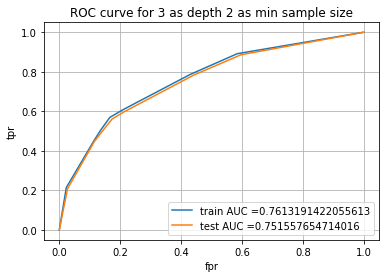

In [0]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred_ts)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title('ROC curve for '+str (best_depth)+' as depth '+str(best_size)+ ' as min sample size')
plt.legend()
plt.grid()
plt.show()

In [0]:
# This section of code where ever implemented is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


print('test')
best_ts_thres = find_best_threshold(te_thresholds, test_fpr, test_tpr)

test
the maximum value of tpr*(1-fpr) 0.47023469028202874 for threshold 0.474


Test Confusion Matrix


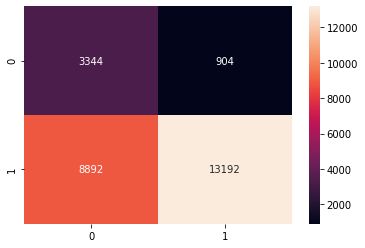

In [0]:
print('Test Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_pred_ts, best_ts_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

In [0]:
acc=accuracy_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
ps=precision_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
rc=recall_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
f1=f1_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 62.80%
Precision on test set: 93.59%
recall score on test set: 59.74%
f1 score on test set: 72.92%


## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tfidf_sent_vectors,final['Score'].values,test_size=0.3,random_state=0)

In [0]:
depth=[2,3,4,6, 8, 9,10,12,14,17]
samples= [2,10,20,30,40,50]
param = {'max_depth':depth,'min_samples_split':samples}

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
DT=DecisionTreeClassifier(class_weight='balanced')
temp_gscv= GridSearchCV(DT,param,cv=5,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 20.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'ma

In [0]:
train_auc=temp_gscv.cv_results_['mean_train_score']
cv_auc=temp_gscv.cv_results_['mean_test_score']

#code snippet from provided 3d scappter plot .ipynb file


import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
import numpy as np

x1 = samples*len(depth)
y1 = depth*len(samples)
z1 = train_auc

x2 = samples*len(depth)
y2 = depth*len(samples)
z2 = cv_auc

# https://plot.ly/python/3d-axes/
trace1 = go.Scatter3d(x=x1,y=y1,z=z1, name = 'train')
trace2 = go.Scatter3d(x=x2,y=y2,z=z2, name = 'CV')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='Sample_size'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
fig.show(renderer='colab')
offline.iplot(fig, filename='3d-scatter-colorscale')

Output hidden; open in https://colab.research.google.com to view.

Train AUC heatmap


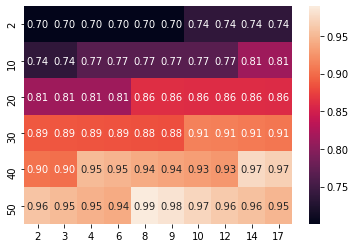

In [0]:
print('Train AUC heatmap')
hm = pd.DataFrame(data= train_auc.reshape(len(samples),len(depth)),index=samples,columns=depth)
sns.heatmap(hm, annot=True,fmt='.2f')

CV AUC heatmap


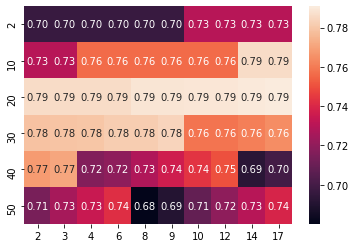

In [0]:
print('CV AUC heatmap')
hm = pd.DataFrame(data= cv_auc.reshape(len(samples),len(depth)),index=samples,columns=depth)
sns.heatmap(hm, annot=True,fmt='.2f')

In [0]:
#finding the best CV scores that is maximas then using the one which is least distant then its AUC counter part to derive  
# C and gamma to avoid using Dumb model.

from scipy.signal import argrelextrema
import numpy as np
x = np.array(train_auc)
y = np.array(cv_auc)

local_max=()
diff=x-y

#finding index of maximas of CV scores 
local_max_i=argrelextrema(y, np.greater)

#generating a list of indexs for maximas
l=list(i for i in local_max_i[0])

#generating list of indices in neighbor of maximas to check
k=[]
neighbor=0
for i in l:
  if i >neighbor and i<len(y):
    k.extend(range(i-neighbor,i+neighbor+1))
  elif i<neighbor and i < len(y):
    k.extend(range(i,i+neighbor+1))
  else:
    k.extend(range(i-neighbor,i+1))
l=k

# diff between CV and Test AUC at the local maximas
local_diff=list(diff[i] for i in l)
print(f'all local differences {local_diff}')

#fetching the index where local diff is min
for i in np.nditer(np.argmin(local_diff)):
  v=i
  break
print(f'best cv score to use = {y[l[v]]}')


best_index= l[v]

print('best index {}'.format(best_index))

# as index are in range of 0 to hundread 
# for differnt permutation of C and gamma
# fetching the C and Gamma index from them

best_depth=depth[int((best_index-(best_index%len(depth)))/len(depth))]
print(f'best depth to use = {best_depth}')

best_size=samples[best_index%len(samples)]
print('best sample split size to use = {}'.format(best_size))

all local differences [0.0729176552316656, 0.06948329805998232, 0.09856258761849468, 0.13038561458572462, 0.17709505664460767, 0.19881122542570162]
best cv score to use = 0.7908410648198686
best index 29
best depth to use = 4
best sample split size to use = 50


In [0]:
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_curve, auc
from sklearn.tree import DecisionTreeClassifier


DT=DecisionTreeClassifier(min_samples_split= best_size, max_depth= best_depth,class_weight='balanced')

DT.fit(X_train,y_train)
y_pred_tr = DT.predict_proba(X_train)
y_pred_ts = DT.predict_proba(X_test)
y_pred_tr=y_pred_tr[:,1]
y_pred_ts=y_pred_ts[:,1]

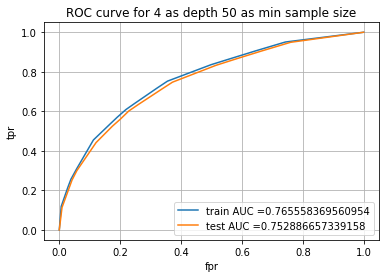

In [0]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred_ts)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title('ROC curve for '+str (best_depth)+' as depth '+str(best_size)+ ' as min sample size')
plt.legend()
plt.grid()
plt.show()

In [0]:
# This section of code where ever implemented is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


print('test')
best_ts_thres = find_best_threshold(te_thresholds, test_fpr, test_tpr)

test
the maximum value of tpr*(1-fpr) 0.4725656826989297 for threshold 0.514


Test Confusion Matrix


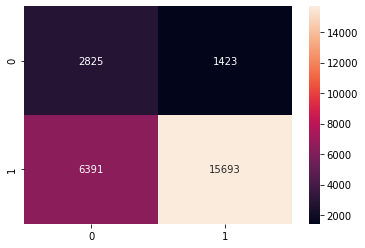

In [0]:
print('Test Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_pred_ts, best_ts_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

In [0]:
acc=accuracy_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
ps=precision_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
rc=recall_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
f1=f1_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 70.33%
Precision on test set: 91.69%
recall score on test set: 71.06%
f1 score on test set: 80.07%


# [6] Conclusions

In [0]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["S.NO.", "Vectorization",  "Max Depth", "Max Sample Split size","Test AUC","Precision Score"]
x.add_row(["1", "BOW", "3", "10","0.6958","91.90%"])
x.add_row(["2", "TFIDF","4", "20","0.7169","91.54%"])
x.add_row(["3", "AVG W2V", "3", "2","0.7515","93.59%"])
x.add_row(["4", "TFIDF W2V", "4", "50","0.7528","91.69%"])
print(x)

+-------+---------------+-----------+-----------------------+----------+-----------------+
| S.NO. | Vectorization | Max Depth | Max Sample Split size | Test AUC | Precision Score |
+-------+---------------+-----------+-----------------------+----------+-----------------+
|   1   |      BOW      |     3     |           10          |  0.6958  |      91.90%     |
|   2   |     TFIDF     |     4     |           20          |  0.7169  |      91.54%     |
|   3   |    AVG W2V    |     3     |           2           |  0.7515  |      93.59%     |
|   4   |   TFIDF W2V   |     4     |           50          |  0.7528  |      91.69%     |
+-------+---------------+-----------+-----------------------+----------+-----------------+


Also there is a significant trade off between precision and recall. This being test data we are mainly concerned about the precision though.

In [0]:
!sudo apt-get install pandoc texlive-xetex
!jupyter nbconvert --to pdf Decision_Trees.ipynb

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
pandoc set to manually installed.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  javascript-common libcupsfilters1 libcupsimage2 libgs9 libgs9-common
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpotrace0 libptexenc1
  libruby2.5 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-extra texlive-latex-recommended texlive-pictures
  texlive-plain-generic tipa
Suggested packages:
  fonts-noto apache2 | lighttpd | httpd poppler-utils ghostscript
  fonts-japan